# Syria Telcom

### Business Problem:

Syria Telcom is losing customers.  It is important to develop a model that can accurately predict those customers who are most likely to 'churn'.  Churn is an industry term used for customers leaving or unsubscribing to a service.  In order to prevent churn or turnover. We must find a model that can identify these customers.

In this case we are most concerned with False Negatives.  Recall will be a very important metric.  Recall will tell us what percentage of the customers that have churned we can properly identify.  Keeping False negatives low becomes more important than keeping false positives low because it is much worse to miss identify someone that could leave than to miss label a customer that isn't going to leave.  However we do not want to completely ignore false positives, as it could become quite expensive to allocate resources in the wrong direction.


## Importing Libraries
Potential libraries/tools that will be needed to complete this task

In [48]:
#Usual Suspects
import pandas as pd
import numpy as np
import math
from IPython.display import Image # display saved images
import warnings

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SKLEARN
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, \
precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer


#IBLearn
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE, SMOTENC


## Obtain the Data

The data for this project is in a .csv file saved as 'data/telcom.csv'

It is imported below and the first five rows are being displayed.

In [2]:
##import data 
df = pd.read_csv('data/telcom.csv')
##display head
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Target
We have a binary target.  
* False -> No Churn
* True -> Churn 

We will eventually convert this column to 0,1 but it will still be a categorical variable.  0 will be false/no churn and 1 will be true/churn.  


In [3]:
df['churn']

0       False
1       False
2       False
3       False
4       False
        ...  
3328    False
3329    False
3330    False
3331    False
3332    False
Name: churn, Length: 3333, dtype: bool

## Inspect / Clean Data
Below we will get an idea of what the dataset looks like and decide if there is any necessary cleaning that is needed.

In [4]:
#Get column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

It looks like we do not have missing data issues.  Area Code is a column of concern at this point.  This will end up in categorical variable list.

In [5]:
#Getting Differential Statistics
pd.set_option('display.max_columns',None) #make sure we are getting all of our columns
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Nothing in the descriptive data looks suspicious at this point.  

## Train Test Split

Data is being split into training and testing sets. This keeps our validation data separate to prevent data leakage.
Data leakage will corrupt the integrity of our model by allowing data that is supposed to be unknown into the training of our model.


* Target variable (y): 'churn'
* Features(X) - all other columns

Also changing the data type of our target column 'churn' to integer.  Currently it is boolean(True/False  

In [6]:
#train_test_split drop churn
#also drop phone 
X = df.drop(columns=['phone number','churn'],axis=1)
y = df['churn'].astype(int)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [7]:
X_train.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,UT,243,510,no,no,0,95.5,92,16.24,163.7,63,13.91,264.2,118,11.89,6.6,6,1.78,2
1373,SC,108,415,no,no,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4
679,TX,75,415,yes,no,0,222.4,78,37.81,327.0,111,27.80,208.0,104,9.36,8.7,9,2.35,1
56,CO,141,415,no,no,0,126.9,98,21.57,180.0,62,15.30,140.8,128,6.34,8.0,2,2.16,1
1993,IN,86,510,no,no,0,216.3,96,36.77,266.3,77,22.64,214.0,110,9.63,4.5,3,1.22,0


In [8]:
#get the size of the dataset
orig_dim = X_train.shape
print('Rows: {} \t Columns: {}'.format(orig_dim[0],orig_dim[1]))

Rows: 2666 	 Columns: 19


## Inspect the Target
This is used to see what are target data looks like.  
Getting the value counts and their percentages will help us make decisions moving forward.
This is a binary classification which most likely will have a small minority sample.  

In [9]:
no_ch, churn = y.value_counts()
no_per, c_per = y.value_counts(normalize=True)
print('No Churn: {} \t{}\nChurn: {}\t{}'.format(no_ch,no_per,churn,c_per))

No Churn: 2850 	0.8550855085508551
Churn: 483	0.14491449144914492


Target is definitely imbalanced will need to use SMOTE later....

# Inspect X_train
X_train.head()
do a pairplot to help with feature selection

In [10]:
X_train.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,UT,243,510,no,no,0,95.5,92,16.24,163.7,63,13.91,264.2,118,11.89,6.6,6,1.78,2
1373,SC,108,415,no,no,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4
679,TX,75,415,yes,no,0,222.4,78,37.81,327.0,111,27.80,208.0,104,9.36,8.7,9,2.35,1
56,CO,141,415,no,no,0,126.9,98,21.57,180.0,62,15.30,140.8,128,6.34,8.0,2,2.16,1
1993,IN,86,510,no,no,0,216.3,96,36.77,266.3,77,22.64,214.0,110,9.63,4.5,3,1.22,0


## Pairplot the Features
This will help us visualize the relationships between our features.  It will help with Feature selection.  At this point it is going to look like a big mess, but there are a few things that we will be able to identify.  

* Categorical Variables:  These will look like straight lines. 
* Correlated Variabels: If there is a perfect linear relationship(diagnol line) then the variables are telling us the same thing




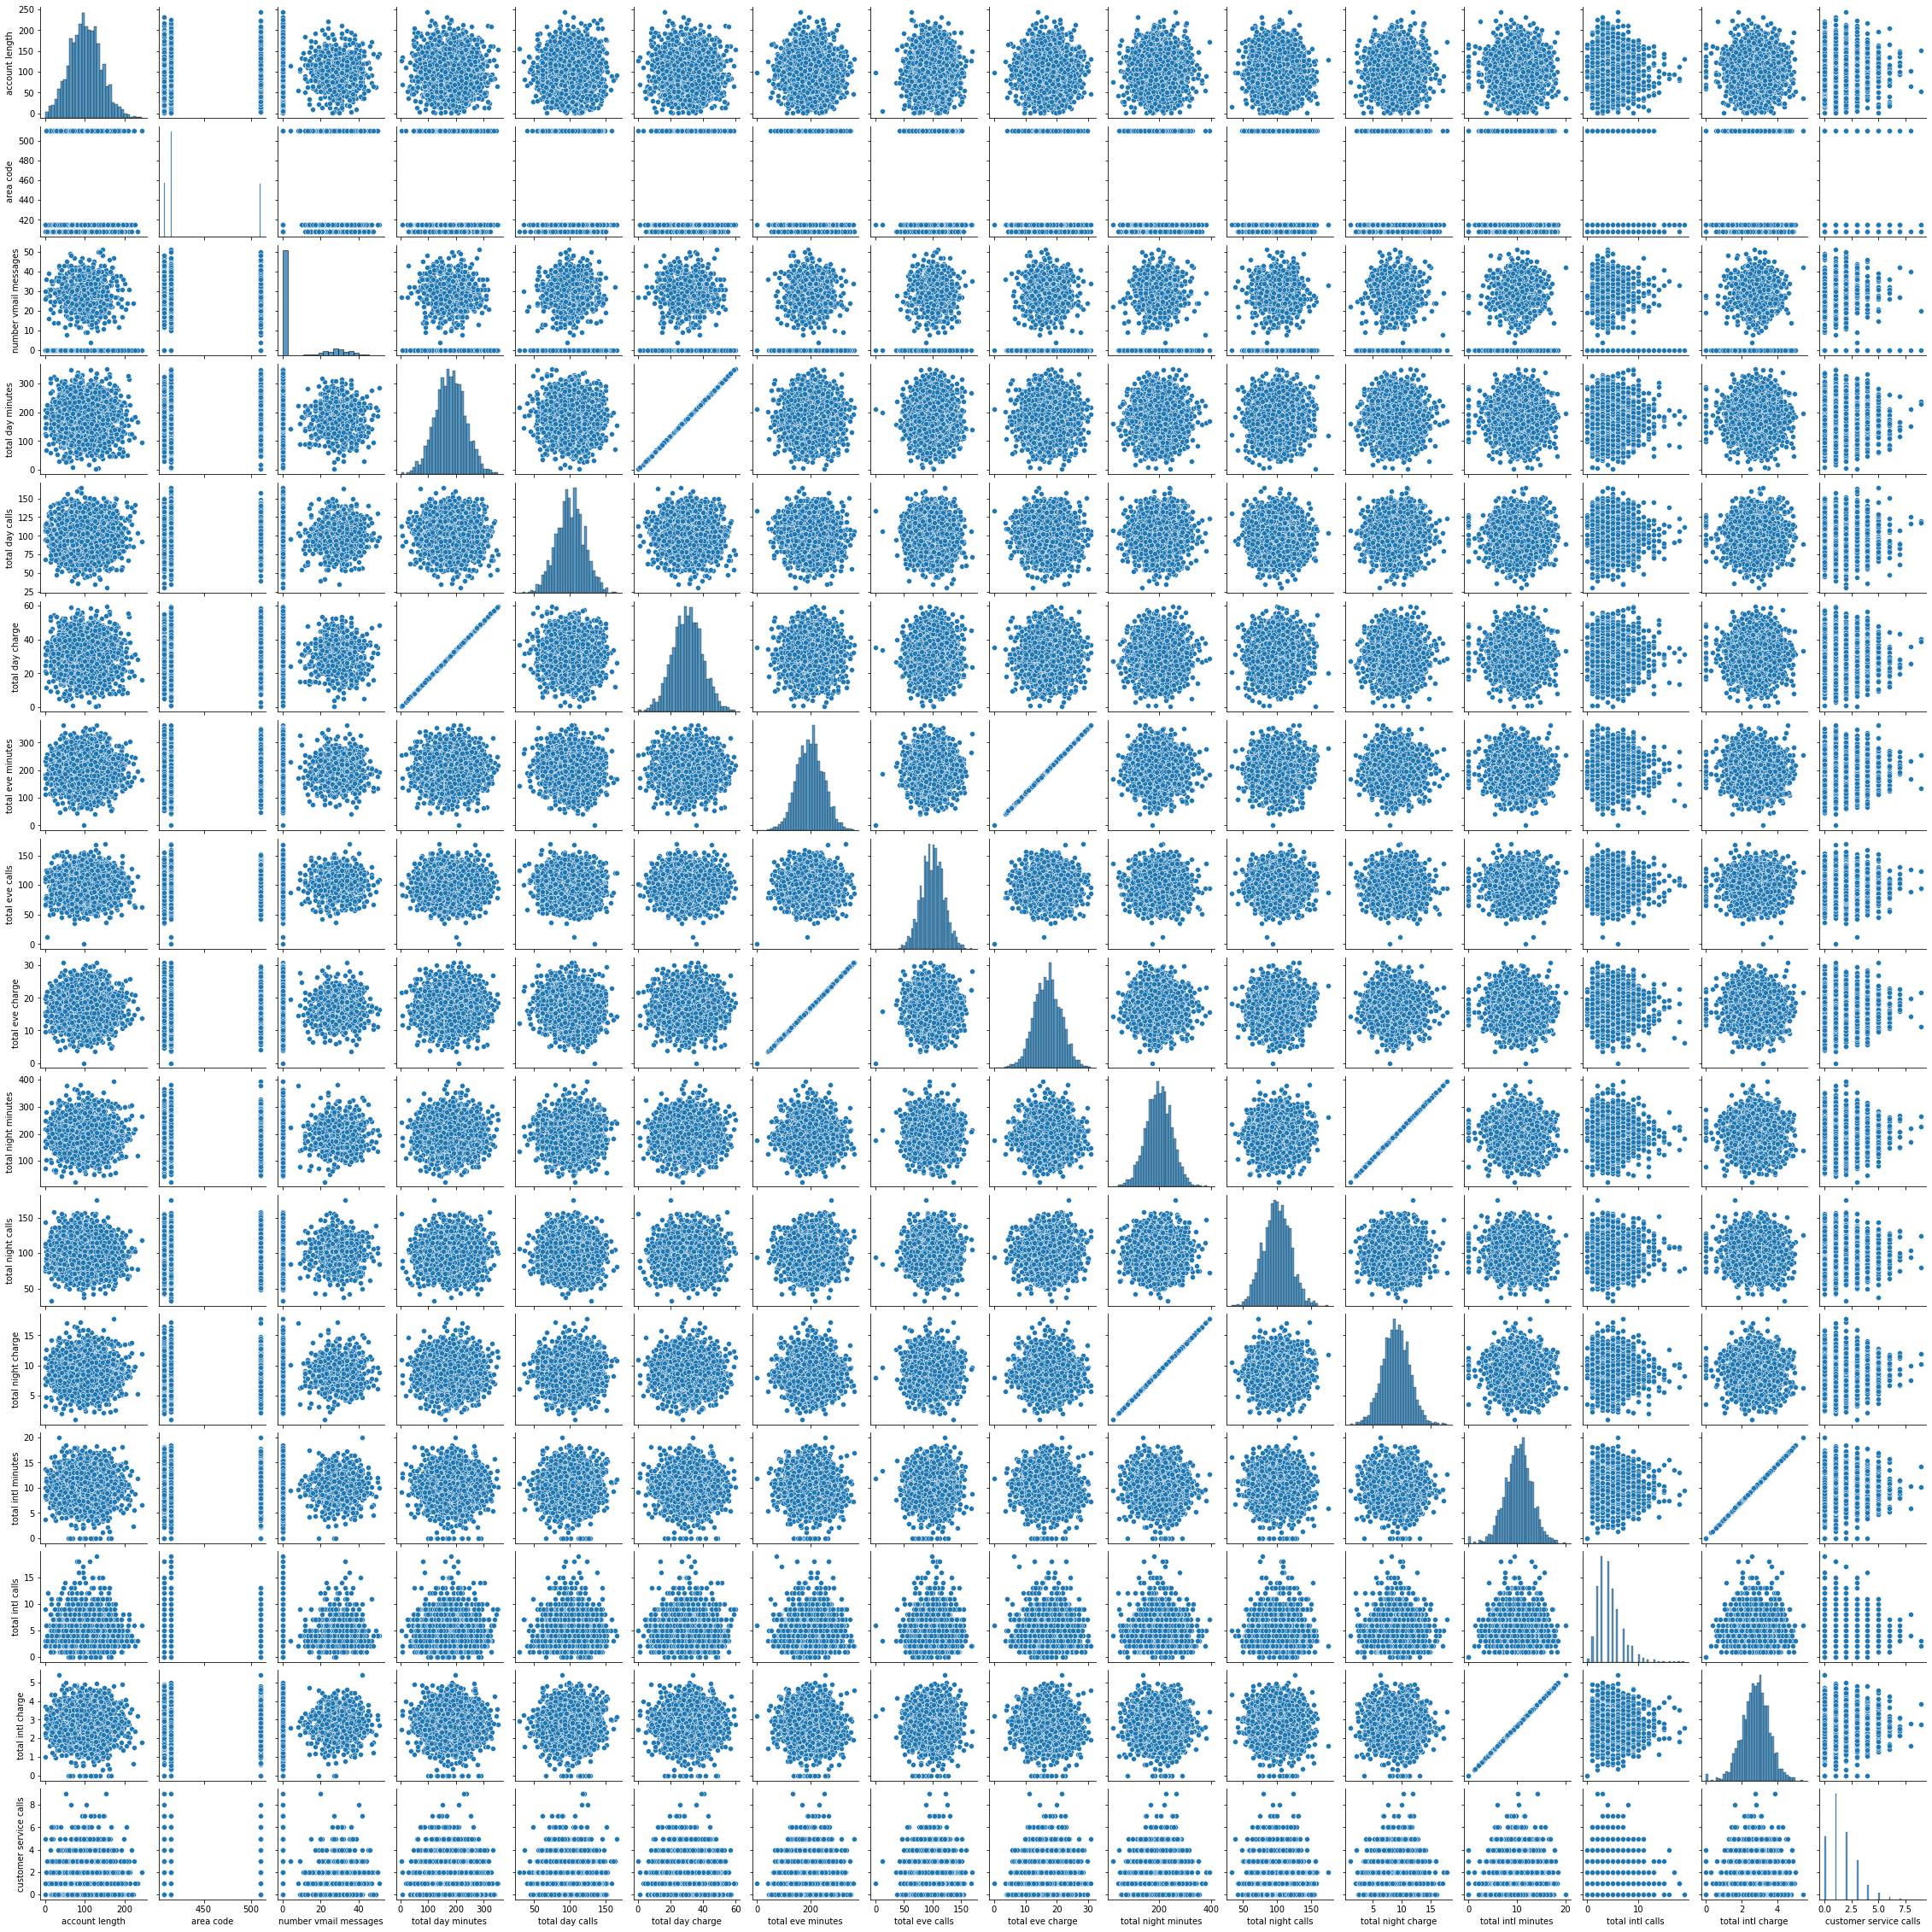

In [11]:
#use seaborn pairplot
#code is commented out to save time.  Pairplot will take a few minutes to run
'''
sns_plot = sns.pairplot(X_train, height=2.0)
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
plt.show()
'''
Image(filename='images/pairplot.png') # Show pairplot as image


## Pairplot Analysis

It is not easy to see the names, but all the charges and total minutes columns are basically giving us the same data

total day minutes, total day charge      
total eve minutes, total eve charge      
total night minutes, total night charge      
total intl minutes, total intl charge

to be consisitent lets drop the columns with minutes in the name. 

area code can probably be considered a categorical variable we can look at that below.

customer service calls appears to be categorical but that column is telling us how many times a customer called.  This is better left as a continous variable.


## Dropping Columns from PairPlot

In [12]:
drop_cols = ['total day minutes','total eve minutes','total night minutes','total intl minutes']

X_train = X_train.drop(columns=drop_cols,axis=1)
X_train.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
817,UT,243,510,no,no,0,92,16.24,63,13.91,118,11.89,6,1.78,2
1373,SC,108,415,no,no,0,105,19.04,110,16.46,93,9.40,4,1.11,4
679,TX,75,415,yes,no,0,78,37.81,111,27.80,104,9.36,9,2.35,1
56,CO,141,415,no,no,0,98,21.57,62,15.30,128,6.34,2,2.16,1
1993,IN,86,510,no,no,0,96,36.77,77,22.64,110,9.63,3,1.22,0


## Area Code
looking at the unique values in area code

In [13]:
X_train['area code'].unique()

array([510, 415, 408])

We can see that we have only 3 area codes in our database we will treat this as a categorical variable.

##  Drop State -  
Dropping state column from data to prevent creating a column for each state.

## Column Transformation

* OneHotEncoder- 'area code' 'international plan', 'voice mail plan'
    * using drop first we will basically create two binary columns for
        * international plan 0-no 1-yes
        * voice mail plan 0-no 1-yes

* StandardScaler - account length','total day calls',
              'total day charge','total eve calls',
              'total eve charge','total night calls',
              'total night charge','total intl calls',
              'total intl charge','customer service calls'
    * standard scaler removes the mean and scales these features to unit variance.
    * this elimates the affect that the range of numbers for each feature can affect their importance.

In [14]:
#drop state
X_train = X_train.drop('state',axis=1)

In [15]:
#take another look at X_train
X_train.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
817,243,510,no,no,0,92,16.24,63,13.91,118,11.89,6,1.78,2
1373,108,415,no,no,0,105,19.04,110,16.46,93,9.40,4,1.11,4
679,75,415,yes,no,0,78,37.81,111,27.80,104,9.36,9,2.35,1
56,141,415,no,no,0,98,21.57,62,15.30,128,6.34,2,2.16,1
1993,86,510,no,no,0,96,36.77,77,22.64,110,9.63,3,1.22,0


In [23]:
drop_dim = X_train.shape
print('Dimensions after drop.  Should still have 2666 columns, but we dropped 5 columns.')
print('Rows: {}\t Columns: {}'.format(drop_dim[0],drop_dim[1]))#(2666,15)

Dimensions after drop.  Should still have 2666 columns, but we dropped 5 columns.
Rows: 2666	 Columns: 14


##  Column Transformation Logic
Below we will create a column transformer using sklearn.compose  ColumnTransformer()

This will make it easier for us to perform the same steps on the test data once we have our opitimized model.

The big concern of this step was keeping track of the column headings.  While ultimately the column headings will not affect the models prediction, they will definitely help prevent human errors during the development process.

The drawback of using columntransformes is that the columns will change order.  To handle this concern, I have added 3 lists below:
* encode_cols - OrdinalEncoder()
* one_hot_cols - OneHotEncoder()
* scale_cols - StandardScaler()

These lists will be used in the ColumnTransformer with their respected function.  Then they will be combined in the new_col_order list. When combining them together in the new list it is essential that they are in the same order as they appear in the ColumnTransformer.  The columns will get reorderd in the DataFrame based on the sequence of the transformer.  The new list will keep track of that order.

In [30]:

#one hot columns (3)
one_hot = OneHotEncoder(sparse='False',drop='first')
one_hot_cols = ['area code','international plan','voice mail plan']
one_hot_labels = ['area code1','area code2','international plan','voice mail plan']
#standard scaler for numerical columns(11)
scale_cols = ['account length','number vmail messages','total day calls',
              'total day charge','total eve calls',
              'total eve charge','total night calls',
              'total night charge','total intl calls',
              'total intl charge','customer service calls']

scaler = StandardScaler()

#keep track of column headings(14)
#this needs to be updated to account for extra area code column
new_col_order = one_hot_labels + scale_cols

#column transformer
ct = ColumnTransformer(transformers=[
    ('ohe',one_hot, one_hot_cols),
    ('ss',scaler, scale_cols)],
    remainder='passthrough'
)



## Fit_Transform The Column Transformer
We will fit and transform our X_train.  This is where we use our new_col_order list to get our column titles in the correct location.  Also double check the shape.  It should match our value from above (2666,15)


In [31]:
#perform fit_transform
data=ct.fit_transform(X_train)
#put the DataFrame back together
X_train_trans = pd.DataFrame(data,columns=new_col_order,index=X_train.index)
#display the shape (2666,14)
X_train_trans.shape

(2666, 15)

## Transformed Data
Columns and Rows seem to all be in tact. This is evident by looking at the state, area code, international plan, and voice mail plan columns.  If column names were out of order, these columns would provide the evidence. During testing of this transformer, some of these columns had the scaled data instead of binary or ordinal data.  

The column names will only matter if we decide to drop a column during model testing because of industry knowledge.  For example if our business decides that account length is no longer a meaningful piece of data or is no longer collected and we need to remove it from our model, we want to be sure that we are removing the appropriate column.

The other data columes below should be scaled(or appear to be scaled and not binary or ordinal encoded)

In [32]:
X_train_trans.head()

,area code1,area code2,international plan,voice mail plan,account length,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
817,0.0,1.0,0.0,0.0,3.601382,-0.584936,-0.429657,-1.547170,-1.840891,-0.731087,0.925634,1.256197,0.634849,-1.304132,0.318978
1373,1.0,0.0,0.0,0.0,0.184951,-0.584936,0.224176,-1.244071,0.499864,-0.139179,-0.353704,0.164841,-0.184370,-2.191525,1.813519
679,1.0,0.0,1.0,0.0,-0.650176,-0.584936,-1.133785,0.787772,0.549667,2.493068,0.209205,0.147309,1.863677,-0.549186,-0.428293
56,1.0,0.0,0.0,0.0,1.020079,-0.584936,-0.127888,-0.970200,-1.890695,-0.408439,1.437368,-1.176344,-1.003589,-0.800835,-0.428293
1993,0.0,1.0,0.0,0.0,-0.371801,-0.584936,-0.228477,0.675192,-1.143645,1.295326,0.516246,0.265649,-0.593980,-2.045833,-1.175564


# Baseline Model
Creating a dummy model that will just pick based on the dominant target class no churn.  This will serve as our baseline model.  This will predict No Churn every time.  Our model should have an accuracy score of 85%.  This is not great because we are not identifying the customers that are leaving(churn).  

In [33]:
## Dummy model
dummy_model = DummyClassifier(strategy='most_frequent')
#fit the model
dummy_model.fit(X_train_trans,y_train)
#check to see if the model is actually predicting all 0's - No Churn
dummy_model.predict(X_train_trans)[:30] #display first 30 -  see all zeros


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

Hopefully there were no churns predicted.

## Cross Validation Baseline Model

In [34]:
cv_res = cross_val_score(dummy_model, X_train_trans, y_train, cv=5)
print('The mean from cv results is {}. \nThis should be around 85% based on our no churn percent'\
      .format(np.mean(cv_res)))

The mean from cv results is 0.8567145196084631. 
This should be around 85% based on our no churn percent


## Confusion Matrix Baseline Model

Our baseline model is predicting all no churns.  We should see that below in our confusion matrix and confusion matrix plot.  

In [35]:
#get predictions from y_train
y_preds = dummy_model.predict(X_train_trans)
#print confusion matrix
confusion_matrix(y_train,y_preds)

array([[2284,    0],
       [ 382,    0]])

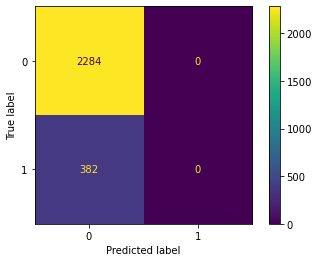

In [36]:
#plot confusion matrix
plot_confusion_matrix(dummy_model,X_train_trans,y_train)

## Score Baseline Model

Our accuracy at this point should match the 85% from our no churn.  We are just guessing that all customers are staying put.  

Recall, Precision and F1_Score will also be 0 because we are not guessing 
TP-True Positive, TN - True Negative, FN - False Negative, FP - False Positive

Recall - TP / (TP + FN)  -  This should result in 0 because we have no True Positives.

Precision - TP / (TP + FP) - This will give us a zero division error because we have 0 TP and 0 FP

F1 Score - Harmonic Mean between Recall an Precision -  This should also be 0

We will build these metrics into our Class Below

In [37]:
dummy_model.score(X_train_trans, y_train)

0.8567141785446362

In [38]:
#recall score  --  should be 0 we have 0 guesses for churn
dummy_recall = recall_score(y_train, y_preds)
dummy_recall

0.0

In [41]:
#precision score -- should be 0 we have 0 guesses for churn
dummy_precision = precision_score(y_train, y_preds, zero_division='warn')
dummy_precision

0.0

In [40]:
#f1 score -- should be 0 we have 0 guesses for churn
dummy_f1 = f1_score(y_train,y_preds)
dummy_f1

0.0

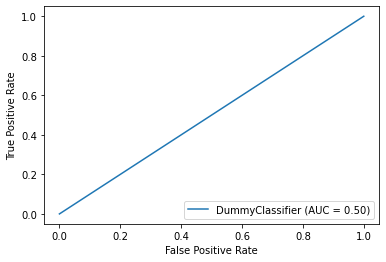

In [42]:
#auc_roc
plot_roc_curve(dummy_model, X_train_trans, y_train)

The AUC-ROC curve for our dummy baseline model should be a diagnol line from 0,0 to 1,1 indicating that our model is no better than a 50/50 guess.  Any AUC-ROC curve above the baseline curve is considered doing better than the baseline.

## Model Testing Class

This model will help expediate the testing process of our models we will add the features tested above.

Model Summary will show warning on the Baseline Model because precison will have a zero_divison error.

In [43]:
class Model_test():
    
    '''
    This class will be used to quickly test and save models for comparison
    This class was modified from lecture: Classifican Workflow - Flatiron School - Greg Damico
    
    '''
    
    def __init__(self, mod_name, model, X, y, run_cv=True):
        self.name = mod_name
        self.model = model
        self.X = X
        self.y = y
        #cross validation
        self.cv_result = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        
        if run_cv:
            self.cross_val()
        
    def cross_val(self, X=None, y=None, kfolds=5):
        '''
        Perform cross validation on the model.
        '''
        #checks to see if user entered other values for X,y
        cv_X = X if X else self.X 
        cv_y = y if y else self.y
        
        self.cv_results = cross_val_score(self.model,cv_X,cv_y,cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        self.cv_median = np.median(self.cv_results)
    
        
    #display overall summary
    def print_summary(self):
        res_mean = round(self.cv_mean,4)
        res_std = round(self.cv_std,4)
        print('CV Results for {}\n {} +- {} accuracy'.format(self.name,res_mean,res_std))
        
        #print precision, recall, f1
        y_preds = self.model.predict(self.X)
        prec = precision_score(self.y,y_preds,zero_division='warn')
        rec = recall_score(self.y,y_preds,zero_division='warn') 
        f1s = f1_score(self.y,y_preds,zero_division='warn')
        
        print('\n\nPrecision:{}\tRecall:{}\tF1_Score:{}'.format(prec,rec,f1s))
        
        #plot roc_curve
        print('\nROC CURVE')
        plot_roc_curve(self.model, self.X, self.y)
        plt.show()
        
        #plot confusion matrix
        print('\nCONFUSION MATRIX')
        plot_confusion_matrix(self.model,self.X, self.y,cmap='YlGnBu')
        plt.show()
   #returns the models recall score.  This is our chosen metric.      
    def model_recall(self):
        y_preds = self.model.predict(self.X)
        return recall_score(self.y,y_preds,zero_division='warn') 
        
        

## Baseline Results and Summary

Calling the class with our dummy_model and then printing the summary.  This process will let us know that our class is working properly and will be able to test all models in our iterative modeling process.

In [44]:
dummy_model_results = Model_test('Dummy',dummy_model, X_train_trans, y_train)

CV Results for Dummy
 0.8567 +- 0.0009 accuracy


Precision:0.0	Recall:0.0	F1_Score:0.0

ROC CURVE


/Users/christopherflynn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


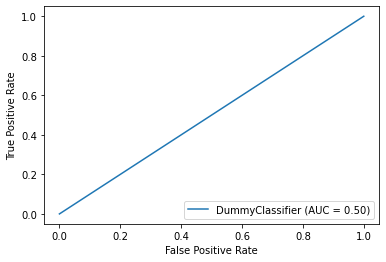


CONFUSION MATRIX


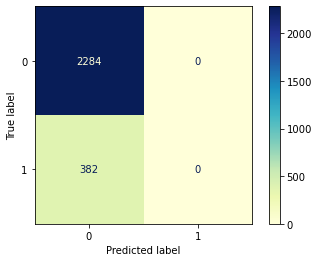

In [46]:
#you may get zero division error warnings from precision at this point.  
dummy_model_results.print_summary()

## SMOTE - Synthetic Minority Over-Sampling Technique
We will use SMOTE to give us some synthetic data points in our minority class.  Our minority class in this instance is customers that churn.  Our current breakdown in our X_test is 85% - No Churn 15% - Churn

SMOTE uses a strategy of K nearest neighbors to create artificial data.

SMOTE is from the imblearn.over_sampling

***Need to use SMOTENC because we have binary columns***
binary columns will add non binary data during a standard smote.

In [50]:
X_train_trans.head()

,area code1,area code2,international plan,voice mail plan,account length,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
817,0.0,1.0,0.0,0.0,3.601382,-0.584936,-0.429657,-1.547170,-1.840891,-0.731087,0.925634,1.256197,0.634849,-1.304132,0.318978
1373,1.0,0.0,0.0,0.0,0.184951,-0.584936,0.224176,-1.244071,0.499864,-0.139179,-0.353704,0.164841,-0.184370,-2.191525,1.813519
679,1.0,0.0,1.0,0.0,-0.650176,-0.584936,-1.133785,0.787772,0.549667,2.493068,0.209205,0.147309,1.863677,-0.549186,-0.428293
56,1.0,0.0,0.0,0.0,1.020079,-0.584936,-0.127888,-0.970200,-1.890695,-0.408439,1.437368,-1.176344,-1.003589,-0.800835,-0.428293
1993,0.0,1.0,0.0,0.0,-0.371801,-0.584936,-0.228477,0.675192,-1.143645,1.295326,0.516246,0.265649,-0.593980,-2.045833,-1.175564


In [54]:
#Before smote
print('Before Smote\n', y_train.value_counts())
# create a smote
smote = SMOTENC(random_state=42, categorical_features=[0,1,2,3])
# fit and resample on X_train and y_train
X_train_resample, y_train_resample = smote.fit_resample(X_train_trans,y_train)

#after smote
print('\nAfter Smote\n', y_train_resample.value_counts())

Before Smote
 0    2284
1     382
Name: churn, dtype: int64

After Smote
 1    2284
0    2284
Name: churn, dtype: int64


In [55]:
X_train_trans.head()

,area code1,area code2,international plan,voice mail plan,account length,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
817,0.0,1.0,0.0,0.0,3.601382,-0.584936,-0.429657,-1.547170,-1.840891,-0.731087,0.925634,1.256197,0.634849,-1.304132,0.318978
1373,1.0,0.0,0.0,0.0,0.184951,-0.584936,0.224176,-1.244071,0.499864,-0.139179,-0.353704,0.164841,-0.184370,-2.191525,1.813519
679,1.0,0.0,1.0,0.0,-0.650176,-0.584936,-1.133785,0.787772,0.549667,2.493068,0.209205,0.147309,1.863677,-0.549186,-0.428293
56,1.0,0.0,0.0,0.0,1.020079,-0.584936,-0.127888,-0.970200,-1.890695,-0.408439,1.437368,-1.176344,-1.003589,-0.800835,-0.428293
1993,0.0,1.0,0.0,0.0,-0.371801,-0.584936,-0.228477,0.675192,-1.143645,1.295326,0.516246,0.265649,-0.593980,-2.045833,-1.175564


Now we have 2284 Churns and 2284 No Churn

## Rerun Baseline Model

Our baseline Model should now have a 50% accuracy as we now have equally balanced classes.
Our other metrics should be the same as we are still only guessing No Churn.

CV Results for Dummy
 0.4998 +- 0.0003 accuracy


Precision:0.0	Recall:0.0	F1_Score:0.0

ROC CURVE


/Users/christopherflynn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


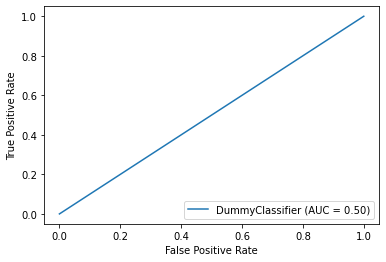


CONFUSION MATRIX


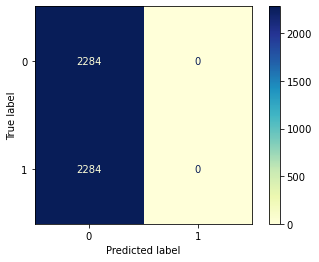

In [56]:
#rerunning baseline model
dummy_model_results = Model_test('Dummy',dummy_model, X_train_resample, y_train_resample)
dummy_model_results.print_summary()

## Baseline Model Results

We can see that we are still guessing no churn and our accuracy is now 50%.  All other metrics are unchanged because we still have not predicted any churns.

Remember that we are concerned with Recall.  In order to increase Recall we would have to predict churn.

We now have a better idea of the performance of our baseline model.  Moving forward we will be testing our models using the data in X_train_resample and y_train_resample.  


## Iterative Modeling
Now that we have a tool to evaluate our models we can begin our process of finding the best model.

We will start by comparing results from the following models

* LogisticRegression()
* DecisionTreeClassifier()
* RandomForestClassifier()

It will be benificial and time saving to build something to test a variety of models and find the best opitons.  We can create a dictionary below and add the baseline results.  Remember we now have a balanced dataset so accuracy can be used.  We still want to keep in mind that we are most concerned with False Negatives.  False Negatives are when we guess that a customer will not churn and they do.   False Positives are also important because we do not want to spend money on customers unnecessarily or annoy/overwhelm them with emails, letters etc. This still makes our main priority Recall.

Let's have our dictionary keep track of Recall scores.

In [57]:
dummy_model_results.model_recall()

0.0

In [58]:
##create a dictionary to store results of tests
model_dict = {}
model_dict['baseline'] = dummy_model_results.model_recall()
model_dict

{'baseline': 0.0}

## Logistic Regression



CV Results for Logistic Regression
 0.7577 +- 0.0149 accuracy


Precision:0.7596529284164859	Recall:0.7666374781085814	F1_Score:0.7631292220527348

ROC CURVE


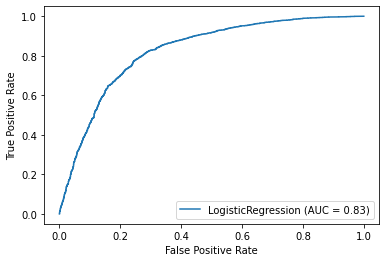


CONFUSION MATRIX


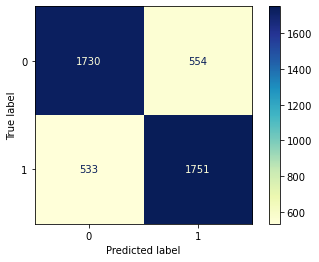

In [59]:
#simple Logistic Regression
log_reg = LogisticRegression(random_state=42,max_iter=1000)
log_reg.fit(X_train_resample,y_train_resample)
log_reg_result = Model_test('Logistic Regression',log_reg,X_train_resample, y_train_resample)
log_reg_result.print_summary()

## Logisitic Regression Results

We now have scores for all of our metrics because we now have data for our True Positives and False Positives.  This seems to be a very balanced model based on the metrics.  You can already see an improvement by looking at the AUC-ROC curve.  Recall, Accuracy, Precision and F1_Score are all right around 78%.  This is potentially something we can build on.

In [60]:
#add the log_reg to our dictionary
model_dict['Logistic Regression'] = log_reg_result.model_recall()
model_dict

{'baseline': 0.0, 'Logistic Regression': 0.7666374781085814}

## Logistic Regression with GridSearchCV
GridSearch will use parameter inputs to test multiple models and give us the best results


C: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.[more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

GridSearchCV is imported from sklearn.model_selection above



In [61]:
#parameter dictionary
params={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

#set up gridsearchcv
gs = GridSearchCV(estimator=log_reg,param_grid=params,cv=10,scoring='recall')

#fit the grid search
gs.fit(X_train_resample,y_train_resample)



GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='recall')

In [62]:
#get best score
gs.best_params_

{'C': 10}

In [63]:
gs.best_score_

0.7631425725886769

CV Results for Log_Reg Grid Search
 0.7614 +- 0.0156 accuracy


Precision:0.7601908065915004	Recall:0.7675131348511384	F1_Score:0.763834422657952

ROC CURVE


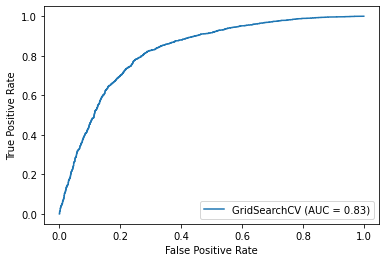


CONFUSION MATRIX


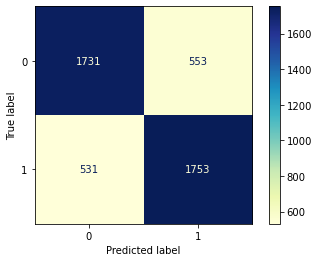

In [64]:
gs_results = Model_test('Log_Reg Grid Search', gs, X_train_resample,y_train_resample)
gs_results.print_summary()

## Logistic Regression with Tuning Results
This helped a little bit with our metrics but higher levels of C will lead to overfitting the training data.  If we come back to LogisticRegression we can look to lower C values and changing other parameters. 


In [65]:
model_dict['Logistic Regression C=100'] = gs_results.model_recall()
model_dict

{'baseline': 0.0,
 'Logistic Regression': 0.7666374781085814,
 'Logistic Regression C=100': 0.7675131348511384}

This model is not performing better than the vanilla logisticRegression().  Lets try some other Classifiers

## Decision Tree
We will now try to fit a Decision Tree

DecisionTreeClassifier() was imported from sklearn.tree
we will use more parameters in our grid search

***Warning this could take a minute or two***

In [67]:
#set up the decision tree
dtc = DecisionTreeClassifier(random_state=42)
#Decision Tree parameters
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [None,3,4,5,6,7,8,10,20,50,100],
          'min_samples_split':[2,3,5,10]
}
#set up Grid Searth with DecisionTreeClassifier
gs = GridSearchCV(estimator=dtc,
                 param_grid=params,
                 cv=10,
                  scoring='recall')
#fit
gs.fit(X_train_resample,y_train_resample)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8, 10, 20, 50, 100],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='recall')

In [68]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 3}

In [69]:
gs.best_score_

0.9347238182793227

**warning this will take a minute**

CV Results for Grid Search Decision Tree
 0.93 +- 0.0444 accuracy


Precision:1.0	Recall:0.9960595446584939	F1_Score:0.9980258828690503

ROC CURVE


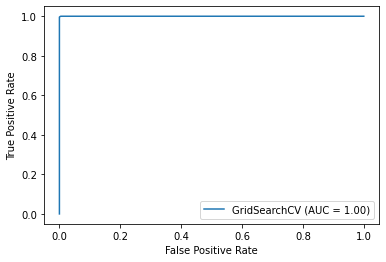


CONFUSION MATRIX


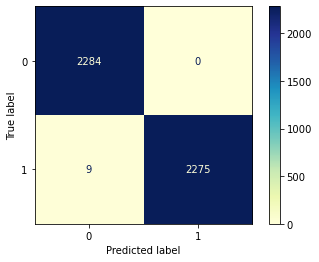

In [70]:
#This will take a minute
gs_results = Model_test('Grid Search Decision Tree',gs, X_train_resample,y_train_resample)
gs_results.print_summary()

Below we can see if we run the optimal parameters DecisionTreeClassifier() to see if we get the same results.

CV Results for Best Decision Tree
 0.9254 +- 0.019 accuracy


Precision:1.0	Recall:0.9960595446584939	F1_Score:0.9980258828690503

ROC CURVE


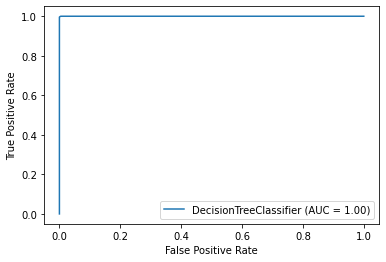


CONFUSION MATRIX


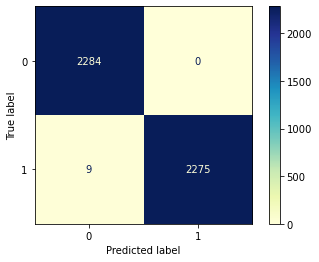

In [71]:
DTC_test = DecisionTreeClassifier(random_state=42, criterion='entropy',max_depth=20,min_samples_split=3)
DTC_test.fit(X_train_resample,y_train_resample)
DTC_test_results=Model_test('Best Decision Tree', DTC_test, X_train_resample,y_train_resample)
DTC_test_results.print_summary()

## Decision Tree Results
This looks very good but DecisionTrees Are prone to overfitting the data.  Our False Negatives and False Positives are 0, and only 9 False Negatives.  We are most likely overfitting with these results.

In [72]:
model_dict['Decision Tree Optimal'] = DTC_test_results.model_recall()
model_dict

{'baseline': 0.0,
 'Logistic Regression': 0.7666374781085814,
 'Logistic Regression C=100': 0.7675131348511384,
 'Decision Tree Optimal': 0.9960595446584939}

## RandomForestClassifier

Do to the high scores of the Decision Tree we will move on to RandomForestClassifier

this is imported from sklearn.ensemble

Random Forest Classifiers help with overfitting by creating many trees.  The ensemble of trees prevents the model from overfitting the training data.  Each tree will use different predictors.  We can limit overfitting by tuning the parameters.  

we will check the criterion like we did with the Decision Tree and we will use max_depth values around 10 because that is what worked in the DecisionTreeClassifier

min_samples_leaf will also be in the grid search.

***Warning This Will Take A Few Minutes***

CV Results for Grid Search Random Forest
 0.9216 +- 0.0338 accuracy


Precision:0.997341603898981	Recall:0.9855516637478109	F1_Score:0.9914115833516847

ROC CURVE


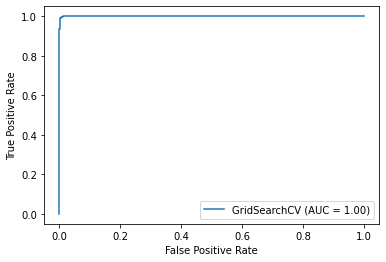


CONFUSION MATRIX


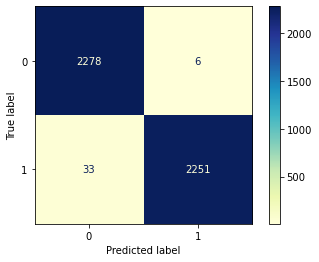

In [73]:
#parameters for RandomForestClassifier
params={'min_samples_leaf':[1,5,10],
       'criterion':['gini','entropy'],
        'max_depth':[7,10,13]}

#set up the RandomForest
rfc = RandomForestClassifier(random_state=42)

#create a GridSearchCV
gs=GridSearchCV(estimator=rfc,param_grid=params,cv=10,scoring="recall")

#fit the GridSearchCV
gs.fit(X_train_resample,y_train_resample)

#put into our class Model_test and print summary
gs_results=Model_test('Grid Search Random Forest',gs,X_train_resample,y_train_resample)
gs_results.print_summary()

In [74]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1}

# This would be a great result but the max_depth being set at 13 most likely means that this model is overfit. 
lets use our other optimal parameters and set max_depth to 5.

CV Results for Random Forest Optimal Parameters
 0.9159 +- 0.0087 accuracy


Precision:0.9878220140515223	Recall:0.9233800350262698	F1_Score:0.9545145960624577

ROC CURVE


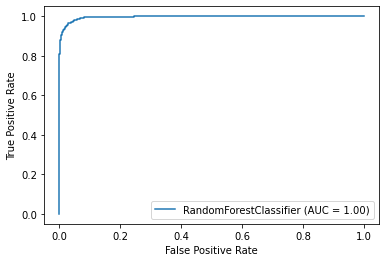


CONFUSION MATRIX


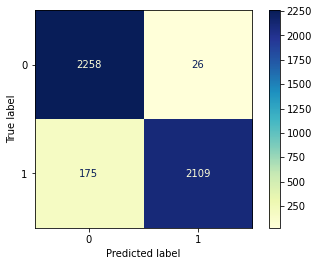

In [76]:
#Optimal Random Forest
rfc_optimal=RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, random_state=42)
#fit the model
rfc_optimal.fit(X_train_resample,y_train_resample)
#put the model into our class Model_test - print the summary
rfc_optimal_results = Model_test('Random Forest Optimal Parameters',rfc_optimal,X_train_resample,y_train_resample)
rfc_optimal_results.print_summary()

## Random Forest Hyper-Parameter Results
This probably helped a little bit with the overfitting.  We are getting better precision scores than recall, so we need to some more adjustment. Before trying another model, lets try some other parameters in our next attempt.


In [77]:
model_dict['Random Forest Hyper'] = rfc_optimal_results.model_recall()
model_dict

{'baseline': 0.0,
 'Logistic Regression': 0.7666374781085814,
 'Logistic Regression C=100': 0.7675131348511384,
 'Decision Tree Optimal': 0.9960595446584939,
 'Random Forest Hyper': 0.9233800350262698}

## Random Forest Part 2
We will now use some other parameters to try to improve recall.  
**This will take awhile**

CV Results for Grid Search Random Forest
 0.8857 +- 0.0129 accuracy


Precision:0.9916317991631799	Recall:0.9338879159369528	F1_Score:0.9618940248027058

ROC CURVE


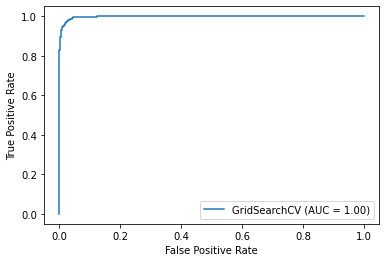


CONFUSION MATRIX


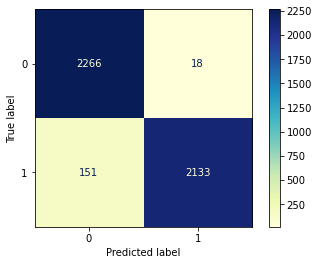

In [78]:
#parameters for RandomForestClassifier2
params={'min_samples_leaf':[1,2],
       'criterion':['gini','entropy'],
        'max_depth':[8,9,10],
       'n_estimators':[50,75,100],
       'max_features':[3,5,7]}

#set up the RandomForest
rfc2 = RandomForestClassifier(random_state=42)

#create a GridSearchCV
gs=GridSearchCV(estimator=rfc2,param_grid=params,cv=5,scoring='recall')

#fit the GridSearchCV
gs.fit(X_train_resample,y_train_resample)

#put into our class Model_test and print summary
gs_results=Model_test('Grid Search Random Forest',gs,X_train_resample,y_train_resample)
gs_results.print_summary()

In [79]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 1,
 'n_estimators': 100}

CV Results for Random Forest Optimal Parameters
 0.9214 +- 0.0082 accuracy


Precision:0.9916317991631799	Recall:0.9338879159369528	F1_Score:0.9618940248027058

ROC CURVE


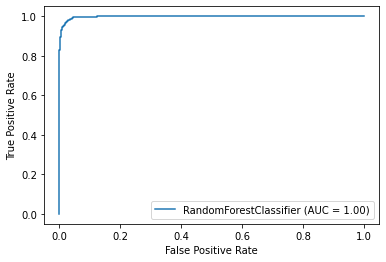


CONFUSION MATRIX


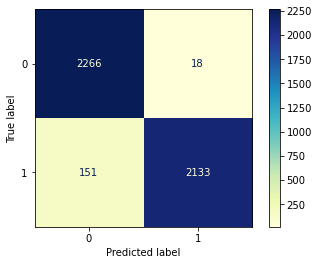

In [80]:
# Random Forest pt 2
rfc2_optimal=RandomForestClassifier(criterion='gini', 
                                    max_depth=10, 
                                    min_samples_leaf=1, 
                                    max_features=5, 
                                    n_estimators=100, 
                                    random_state=42)
#fit the model
rfc2_optimal.fit(X_train_resample,y_train_resample)
#put the model into our class Model_test - print the summary
rfc2_optimal_results = Model_test('Random Forest Optimal Parameters',rfc2_optimal,X_train_resample,y_train_resample)
rfc2_optimal_results.print_summary()

In [81]:
#add results to dictionary
model_dict['Random Forest Hyper2'] = rfc2_optimal_results.model_recall()
model_dict

{'baseline': 0.0,
 'Logistic Regression': 0.7666374781085814,
 'Logistic Regression C=100': 0.7675131348511384,
 'Decision Tree Optimal': 0.9960595446584939,
 'Random Forest Hyper': 0.9233800350262698,
 'Random Forest Hyper2': 0.9338879159369528}

## Random Forest 2 Results
We have a little bit of improvement here but not much.  Before moving to validation with our test data let's look at some feature importance.

## Feature Selection

Before making this our model of choice we should see if we have any features that are not necessarily helping our model.  It will also show us which features are important and help with reccomendations to the stakeholder.

We will use attributes from our sklearn RandomForestClassifier()
.feature_importances gives us the impurity-based feature importances.  Higher values are better.

We will use our column names to create a dictionary.  This will help with plotting

In [82]:
#Gini feature importance
rfc2_optimal.feature_importances_

array([0.00325675, 0.00659837, 0.09219229, 0.02256059, 0.02699185,
       0.03277089, 0.02537979, 0.25763609, 0.02454543, 0.08088351,
       0.03019179, 0.04111824, 0.0793657 , 0.05529806, 0.22121065])

In [83]:
#predictor names
X_train.columns

Index(['account length', 'area code', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day calls', 'total day charge',
       'total eve calls', 'total eve charge', 'total night calls',
       'total night charge', 'total intl calls', 'total intl charge',
       'customer service calls'],
      dtype='object')

In [84]:
# create variables to hold predictor names and their values
features = X_train.columns
values = rfc2_optimal.feature_importances_
# create a dictionary of features with their values
feature_dict = dict(zip(features, values))
feature_dict



{'account length': 0.003256748731787879,
 'area code': 0.006598365048602602,
 'international plan': 0.09219228757792891,
 'voice mail plan': 0.02256058914406689,
 'number vmail messages': 0.026991849019795268,
 'total day calls': 0.03277088710632071,
 'total day charge': 0.025379790206290928,
 'total eve calls': 0.25763609304504764,
 'total eve charge': 0.024545428921961477,
 'total night calls': 0.08088350978336493,
 'total night charge': 0.03019179387162011,
 'total intl calls': 0.04111824244243403,
 'total intl charge': 0.07936569931881042,
 'customer service calls': 0.05529806301090896}

In [85]:
#sort the feature dict for better plotting
sorted_features = dict(sorted(feature_dict.items(), key=lambda x: x[1]))
#put the xlabels in the list for the plot
xlabels = list(sorted_features.keys())
xlabels

['account length',
 'area code',
 'voice mail plan',
 'total eve charge',
 'total day charge',
 'number vmail messages',
 'total night charge',
 'total day calls',
 'total intl calls',
 'customer service calls',
 'total intl charge',
 'total night calls',
 'international plan',
 'total eve calls']

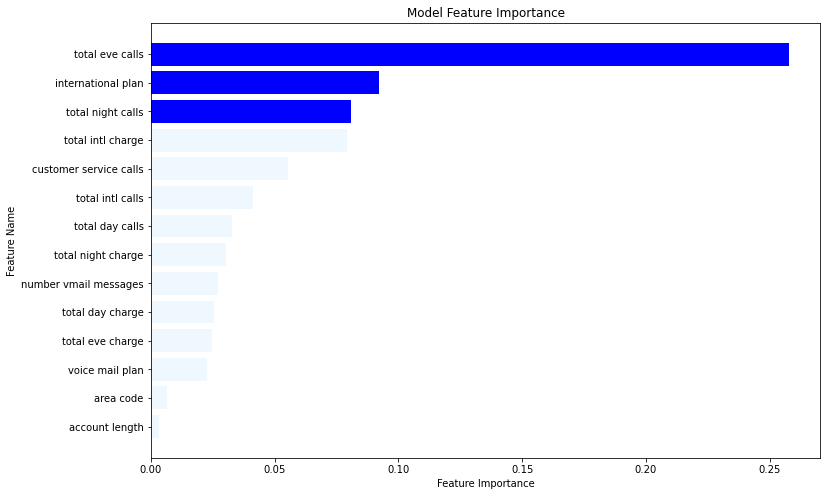

In [95]:
#plot 

values = sorted_features.values()
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]

custom_color = ['aliceblue' if (x < 0.0805) else 'blue' for x in values]
fig=plt.subplots(figsize=(12,8))
plt.barh(range(len(sorted_features)),values , tick_label=xlabels, color=custom_color)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Model Feature Importance')
plt.show()

## Feature Evaluation

Most important features seem to be 
* total eve calls
* international plan
* total night calls

Keep in mind that this is subject to change as new data comes in.  But it would be important look at these three features while makeing our reccomendations


An older version of this model identified the following as the top predictors
* total day charge
* area code
* customer service calls
So you will see data exploration on the following below as well. 
* customer service call processes and how certain customers are handled.  Can we direct certain customers to our best representatives?
* Are there are other plans that we can reccomend for customers that have high total day charges? 
* What is different about our three area codes? Is there more competition in that area? Is the service worse? 

## Model Comparison

lets compare our models using our dictionary model_dict.  Remember that recall is our chosen metric for this.  False Negatives are our worst enemy in this case.

In [120]:
#recall values for plot
model_dict.values()

dict_values([0.0, 0.7666374781085814, 0.7675131348511384, 0.9960595446584939, 0.9233800350262698, 0.9338879159369528])

In [97]:
#models - keys
models = [key for key in model_dict.keys()]
models

['baseline',
 'Logistic Regression',
 'Logistic Regression C=100',
 'Decision Tree Optimal',
 'Random Forest Hyper',
 'Random Forest Hyper2']

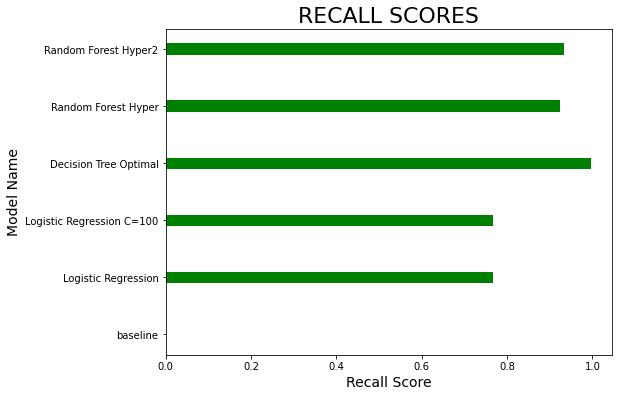

In [98]:
##plot from model dict
values = model_dict.values()

fig=plt.subplots(figsize=(8,6))
plt.barh(range(len(model_dict)), values, tick_label=models, color='green', height=0.2)
plt.xlabel('Recall Score',fontsize =14)
plt.ylabel('Model Name', fontsize=14)
plt.title('RECALL SCORES', fontsize=22)
plt.show()

Our Random Forest performed slightly better than our Decision Tree Optimal.  As stated earlier the Random Forest by nature helps prevent overfitting and this probably makes it a worthwhile choice event though it will take a little more computational time.  Because we only have 15 predictors at this time, running our model shouldn't be that costly.

## Prepare X_test data
We need to do the following to our validation set (X_test)

1. ColumnTransformer() - ct.transform()
2. Add the columns back for verification
3. rfc_optimal with X_test, y_test

In [99]:
#drop state column
X_test.drop('state',axis=1)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
438,113,510,no,no,0,155.0,93,26.35,330.6,106,28.10,189.4,123,8.52,13.5,3,3.65,1
2674,67,415,no,no,0,109.1,117,18.55,217.4,124,18.48,188.4,141,8.48,12.8,6,3.46,0
1345,98,415,no,no,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4
1957,147,408,no,no,0,212.8,79,36.18,204.1,91,17.35,156.2,113,7.03,10.2,2,2.75,1
2148,96,408,no,no,0,144.0,102,24.48,224.7,73,19.10,227.7,91,10.25,10.0,7,2.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,157,510,no,no,0,185.1,92,31.47,213.0,85,18.11,196.1,85,8.82,8.5,5,2.30,2
2763,116,408,no,yes,19,155.7,104,26.47,185.4,118,15.76,192.7,116,8.67,8.2,2,2.21,3
3069,148,415,no,yes,26,158.7,91,26.98,160.5,127,13.64,218.3,88,9.82,9.9,3,2.67,1
1468,75,510,no,yes,27,117.5,102,19.98,206.8,127,17.58,194.4,114,8.75,4.2,7,1.13,3


In [100]:
#original X_test
X_test.head()


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
438,WY,113,510,no,no,0,155.0,93,26.35,330.6,106,28.10,189.4,123,8.52,13.5,3,3.65,1
2674,IL,67,415,no,no,0,109.1,117,18.55,217.4,124,18.48,188.4,141,8.48,12.8,6,3.46,0
1345,SD,98,415,no,no,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4
1957,KY,147,408,no,no,0,212.8,79,36.18,204.1,91,17.35,156.2,113,7.03,10.2,2,2.75,1
2148,WY,96,408,no,no,0,144.0,102,24.48,224.7,73,19.10,227.7,91,10.25,10.0,7,2.70,1


In [101]:
import warnings
warnings.filterwarnings("ignore")
#apply column transformer to x_test transform only!!!
data = ct.transform(X_test)
X_test_trans = pd.DataFrame(data,columns=new_col_order,index=X_test.index)
X_test_trans.head()

,area code1,area code2,international plan,voice mail plan,account length,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
438,0.0,1.0,0.0,0.0,0.311486,-0.584936,-0.379362,-0.452767,0.300651,2.562705,1.181501,-0.220859,-0.593980,1.172620,-0.428293
2674,1.0,0.0,0.0,0.0,-0.852632,-0.584936,0.827714,-1.297113,1.197110,0.329704,2.102624,-0.238391,0.634849,0.920971,-1.175564
1345,1.0,0.0,0.0,0.0,-0.068118,-0.584936,-5.056782,-3.305141,1.495930,-0.810008,-0.609571,-0.659155,-1.413199,-1.224664,1.813519
1957,0.0,0.0,0.0,0.0,1.171920,-0.584936,-1.083490,0.611325,-0.446399,0.067408,0.669766,-0.873920,-1.003589,-0.019400,-0.428293
2148,0.0,0.0,0.0,0.0,-0.118732,-0.584936,0.073292,-0.655194,-1.342858,0.473619,-0.456051,0.537392,1.044458,-0.085623,-0.428293


## Final Model on Test Data 
We will now put our final model to the the test on X_test_trans and y_test

rfc_optimal was our best model

CV Results for Random Forest - Final Model
 0.9221 +- 0.0248 accuracy


Precision:0.7592592592592593	Recall:0.8118811881188119	F1_Score:0.7846889952153111

ROC CURVE


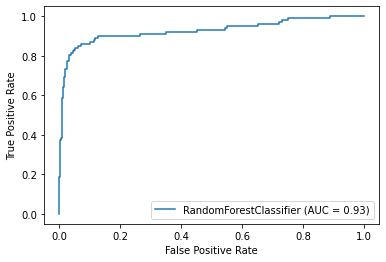


CONFUSION MATRIX


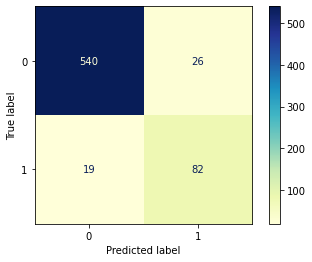

In [102]:
#final model on test data 

final_results = Model_test('Random Forest - Final Model', rfc2_optimal, X_test_trans, y_test)
final_results.print_summary()

In [103]:
26/566

0.045936395759717315

## Final Model Test Results
Our model was able to correctly identify 82 / 101 churns 
while only mislabeling 26 / 566 customers that did not leave

**Recall: 82%**
We were primarily concerned with recall.  Achieving a score of 80% on our test data is encouraging especially because we did not sacrifice our secondary concern of Precision too much.  Looking at our errors we had 19 False Negatives.  We did not identify 18% of the churned customers.  On the other hand we only had 21 False Postives.  Which means we only falsly identified about 4.5% of customers as churn. 


Other Metrics of Note:
* Precision: 76%
* F1_Score: 78%
* Accuracy 92%

** Remember that our pre SMOTE accuracy was 85%.  Post SMOTE we had accuracy of 50%.  We are not really worried about accuracy because the data is unbalanced.  


# Top Feature Visualizations 
We will create visualizations from the data of our top features.  Total Day Charge, Customer Service Calls and Area Code to help make reccomendations to the client.

At this point we are going to to use the entire data set as it will not affect our model training.

In [104]:
#make sure that we still have our original data 
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Churn By Total Day Charge

Total Day Charge was a big factor lets plot churn and total day charge


In [105]:
tot_dc = df.groupby(['churn'])
tot_dc.agg({'total day charge': ['mean', 'min', 'max','std']})

total day charge                       
                  mean  min    max        std
churn                                        
False        29.780421  0.0  53.65   8.530835
True         35.175921  0.0  59.64  11.729710

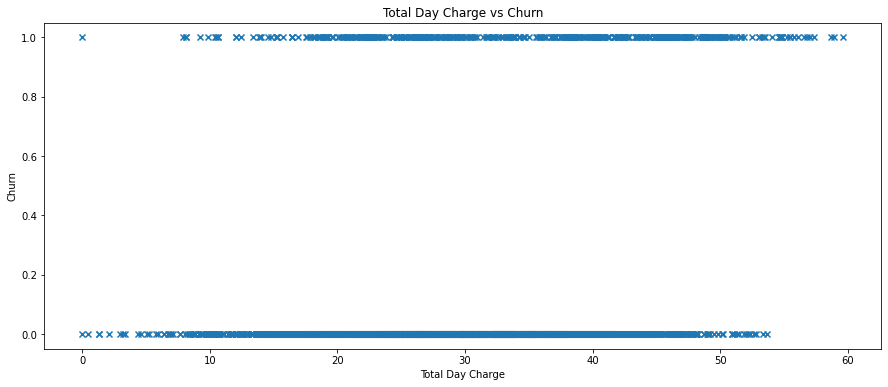

In [106]:
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(df['total day charge'], df['churn'],marker='x')
plt.title('Total Day Charge vs Churn')
plt.ylabel('Churn')
plt.xlabel('Total Day Charge')
plt.show() # Depending on whether you use IPython or interactive mode, etc.

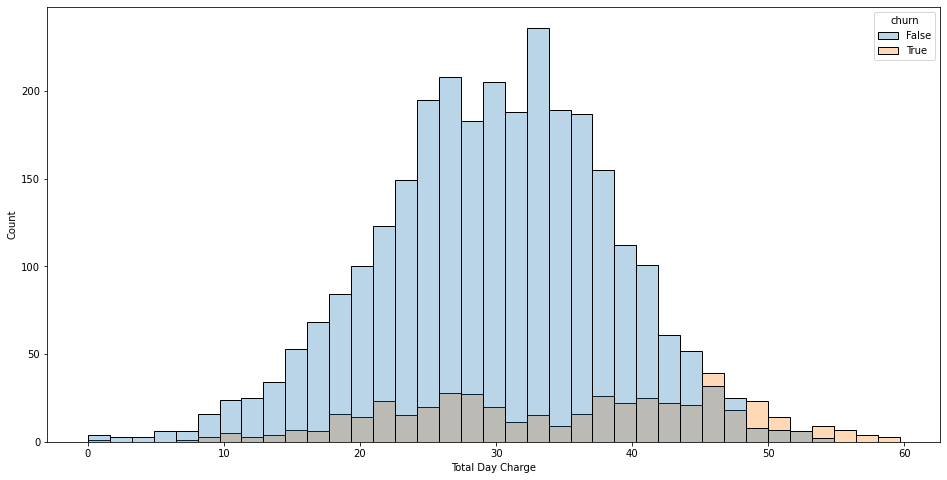

In [107]:
fig,ax = plt.subplots(figsize=(16,8))
ax = sns.histplot(data=df,x='total day charge', hue='churn', alpha=0.3)
ax.set(xlabel='Total Day Charge', ylabel='Count')
plt.show()

It looks like around 45 dollars is where the Churns start taking over.  Look into setting up price points or flat rates to keep customers that are frequent users.

## Churn By Customer Service Calls


In [108]:
tot_dc = df.groupby(['churn'])
tot_dc.agg({'customer service calls': ['mean', 'min', 'max','std']})

customer service calls                  
                        mean min max       std
churn                                         
False               1.449825   0   8  1.163883
True                2.229814   0   9  1.853275

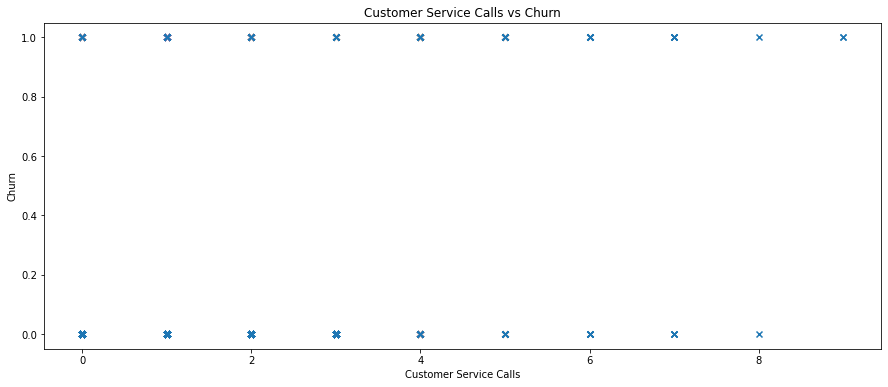

In [109]:
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(df['customer service calls'], df['churn'],marker='x')
plt.title('Customer Service Calls vs Churn')
plt.ylabel('Churn')
plt.xlabel('Customer Service Calls')
plt.show() # Depending on whether you use IPython or interactive mode, etc.

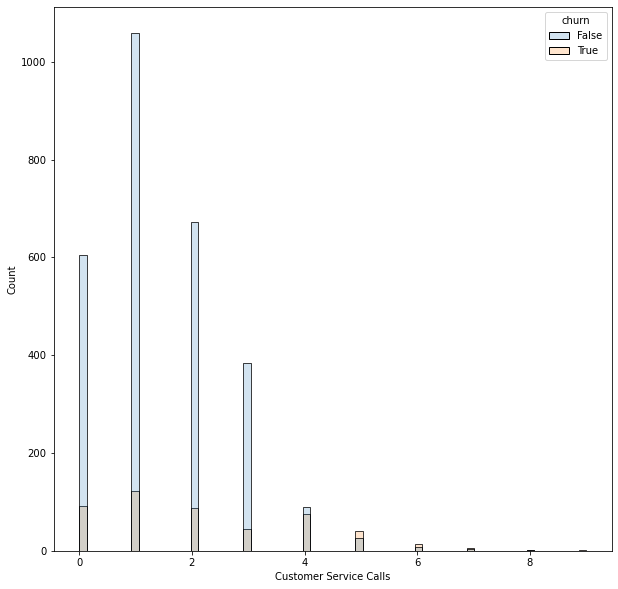

In [110]:
fig,ax = plt.subplots(figsize=(10,10))
ax = sns.histplot(data=df,x='customer service calls', hue='churn',alpha=0.2)
ax.set(xlabel='Customer Service Calls', ylabel='Count')
plt.show()

The average number of calls made by churns was 2.2 vs non churns 1.4
Histogram tells us that after 4 calls churns become dominant. Propose channeling calls to best representatives at 2nd or 3rd call to prevent things from getting to 4th call.  These preventive measures could include promotional offers.

## Churn By Area Code

not sure what happend there...

In [ ]:
df['area code'].value_counts()

In [111]:
#get area code 408,415,510

area_408 = df[df['area code']==408]
area_415 = df[df['area code']==415]
area_510 = df[df['area code']==510]
#area code dictionary 
area_code_dict = {'AREA CODE 408':area_408, 'AREA CODE 415':area_415, 'AREA CODE 510':area_510}
area_408.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
12,IA,168,408,363-1107,no,no,0,128.8,96,21.90,104.9,71,8.92,141.1,128,6.35,11.2,2,3.02,1,False
16,ID,85,408,350-8884,no,yes,27,196.4,139,33.39,280.9,90,23.88,89.3,75,4.02,13.8,4,3.73,1,False
21,CO,77,408,393-7984,no,no,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,True


area code  415


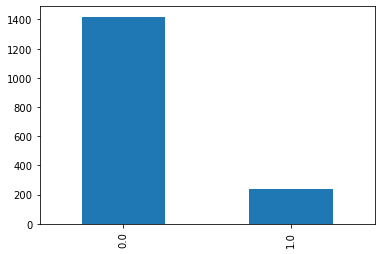

In [112]:
#plot area code 415b 
print('area code ', 415)
fig = area_415['churn'].astype(float).value_counts().plot(kind='bar', stacked=True)

In [113]:
# find percent churn for 415.
vc_415 = area_415['churn'].value_counts()
per_415 = vc_415[1]/(vc_415[0]+vc_415[1])
print('churn percent for 415', round(per_415,4)*100,'%')

churn percent for 415 14.26 %


## create a function to do all area codes.  
There are only 3 but in the future more could be added.  

AREA CODE 408
No Churn:716	Churn: 122	Churn Percentage 0.15


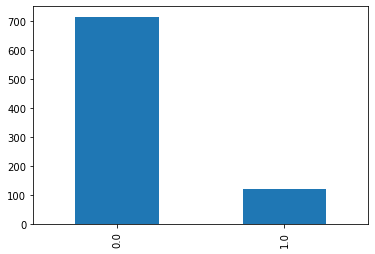

AREA CODE 415
No Churn:1419	Churn: 236	Churn Percentage 0.14


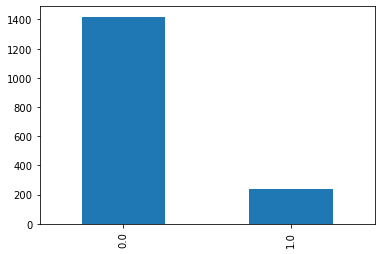

AREA CODE 510
No Churn:715	Churn: 125	Churn Percentage 0.15


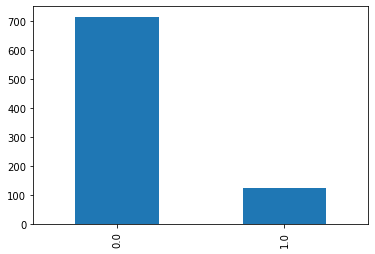

In [114]:
#defining functions to display area code data
def display_ac_data(key, dict, data, plot=True):
    #print out the area code title
    print(key)
    
    #identify the data frame
    data = dict[key]
    #get value counts
    vc = data['churn'].value_counts()
    
    #identify no-churn and churn counts
    no_churn = vc[0]
    churn = vc[1]
    total = no_churn + churn
    
    #display totals and percent churn
    print('No Churn:{}\tChurn: {}\tChurn Percentage {}'.format(no_churn, churn, round(churn/total,2)))
    
    #plot visual
    if plot==True:
        fig = data['churn'].astype(float).value_counts().plot(kind='bar')
        plt.show()
#loop through area code dict
for key in area_code_dict:
    display_ac_data(key,area_code_dict,df)

Not sure how area code is our 2nd highest value predictor when the the percentages for all 3 area codes are around 14-15%.  There must be some combination of factors where customers churned for not other reason than area code. We can try to dig deeper into this. 

Potential avenues to explore

* look at customers with low Total Day Charge that churned and see what area code they were in
* look at customers with low customer service calls that churned and see what area code they were in
* look at combined low total day change and low customer service calls and see what area code break down looks like



## Low Total Day Charge Churners
let's try a few of these out. 

Create a df of churners that had low total day charge.  Lets start around 30.  This number was used by looking at the plot of total day charge above.  

Then plot the churners by area code for that group.


In [115]:
#create dataframe
low_tdc = df[(df['total day charge'] < 30)]
low_tdc

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
10,IN,65,415,329-6603,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
12,IA,168,408,363-1107,no,no,0,128.8,96,21.90,104.9,71,8.92,141.1,128,6.35,11.2,2,3.02,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,IN,117,415,362-5899,no,no,0,118.4,126,20.13,249.3,97,21.19,227.0,56,10.22,13.6,3,3.67,5,True
3324,WV,159,415,377-1164,no,no,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False
3326,OH,96,415,347-6812,no,no,0,106.6,128,18.12,284.8,87,24.21,178.9,92,8.05,14.9,7,4.02,1,False
3327,SC,79,415,348-3830,no,no,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False


In [116]:
low_tdc['area code'].value_counts()

415    772
408    420
510    406
Name: area code, dtype: int64

We can now try running our function again on the zipcode list with our new dataframe

AREA CODE 408
No Churn:373	Churn: 47	Churn Percentage 0.11


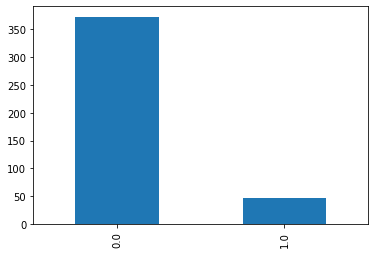

AREA CODE 415
No Churn:686	Churn: 86	Churn Percentage 0.11


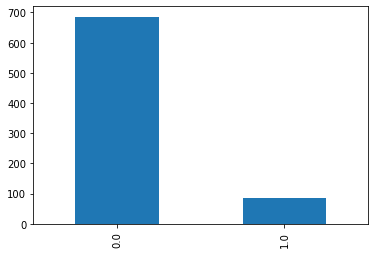

AREA CODE 510
No Churn:353	Churn: 53	Churn Percentage 0.13


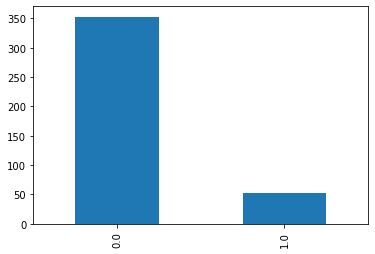

In [117]:
#get area code 408,415,510

area_408 = low_tdc[low_tdc['area code']==408]
area_415 = low_tdc[low_tdc['area code']==415]
area_510 = low_tdc[low_tdc['area code']==510]
#loop through area code dict
#area code dictionary 
area_code_dict = {'AREA CODE 408':area_408, 'AREA CODE 415':area_415, 'AREA CODE 510':area_510}
for key in area_code_dict:
    display_ac_data(key,area_code_dict,low_tdc)

## Checking Different Values of Total Day Charge
Now that we got that to work lets repeat that process for other values of total day charge.  I'm guessing that lower values will show a bigger difference.

We can  call our function in a loop to try to do all of this at once.  We will test the values from 15-25 in increments of 5
and calculate churn percentage for each area code. 

using plot=False to just see values

*******************************
Total Day Charge Less Than  15
AREA CODE 408
No Churn:50	Churn: 4	Churn Percentage 0.07


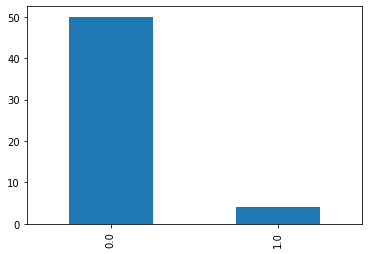

AREA CODE 415
No Churn:60	Churn: 6	Churn Percentage 0.09


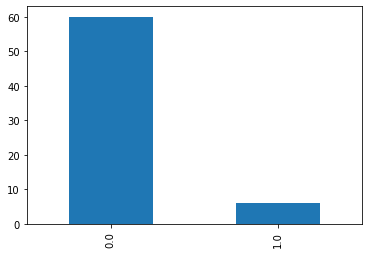

AREA CODE 510
No Churn:28	Churn: 9	Churn Percentage 0.24


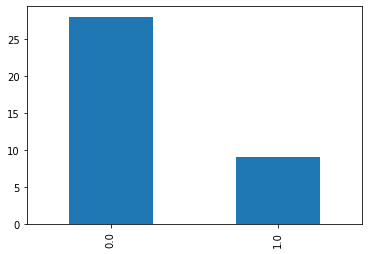

*******************************
Total Day Charge Less Than  20
AREA CODE 408
No Churn:109	Churn: 14	Churn Percentage 0.11


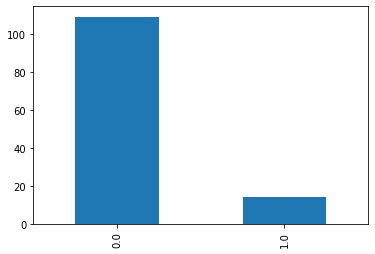

AREA CODE 415
No Churn:172	Churn: 19	Churn Percentage 0.1


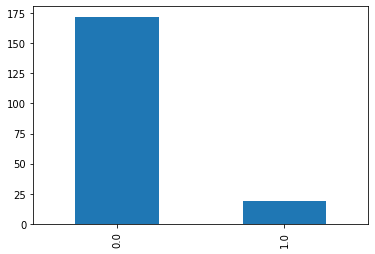

AREA CODE 510
No Churn:92	Churn: 16	Churn Percentage 0.15


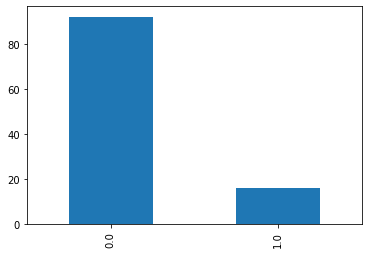

*******************************
Total Day Charge Less Than  25
AREA CODE 408
No Churn:211	Churn: 24	Churn Percentage 0.1


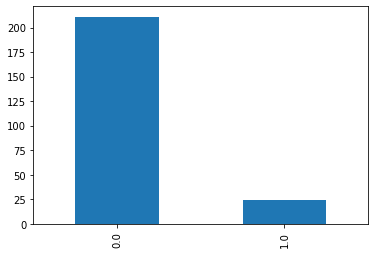

AREA CODE 415
No Churn:394	Churn: 48	Churn Percentage 0.11


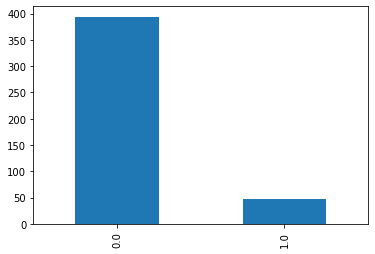

AREA CODE 510
No Churn:199	Churn: 35	Churn Percentage 0.15


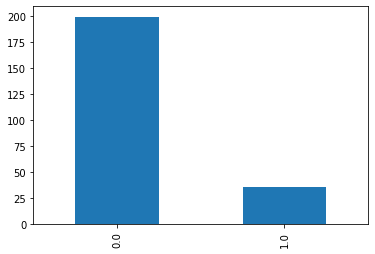

In [118]:
# range of values to test for 'total day charge'
tdc_values=np.arange(15,30,5)
tdc_values

#loop through tdc_values 
for tdc in tdc_values:
    print('*******************************')
    print('Total Day Charge Less Than ', tdc)
    low_tdc = df[(df['total day charge'] < tdc)]
    #create zipcodes
    area_408 = low_tdc[low_tdc['area code']==408]
    area_415 = low_tdc[low_tdc['area code']==415]
    area_510 = low_tdc[low_tdc['area code']==510]
   
    #area code dictionary - 
    area_code_dict = {'AREA CODE 408':area_408, 'AREA CODE 415':area_415, 'AREA CODE 510':area_510}
    #loop through dict and call function
    for key in area_code_dict:
        display_ac_data(key,area_code_dict,low_tdc,plot=True)

## Area Code Insight

It looks like area code 510 has churn percentage around 24% at Total Day Charges less than 15.  This is more than twice as high as the other two area codes.  This helps explain how this can be a top feature when in plain sight it is hard to see much difference between the area codes churn rate.  

## Area Code and Customer Service Calls

Let's revisit customer service calls and attempt something similar by testing different values of customer service calls with our area codes.  Use the values 3-9 taken from our plot above.

Trying to see at what maximum value of customer service calls area code plays the biggest factor.

In [119]:
# customer service call values
csc_values = np.arange(3,10,1)

#loop through tdc_values 
for csc in csc_values:
    print('*******************************')
    print('Customer Service Calls Less Than ', csc)
    low_csc = df[(df['customer service calls'] < csc)]
    #create zipcodes
    area_408 = low_csc[low_csc['area code']==408]
    area_415 = low_csc[low_csc['area code']==415]
    area_510 = low_csc[low_csc['area code']==510]
   
    #area code dictionary - 
    area_code_dict = {'AREA CODE 408':area_408, 'AREA CODE 415':area_415, 'AREA CODE 510':area_510}
    #loop through dict and call function
    for key in area_code_dict:
        display_ac_data(key,area_code_dict,low_csc,plot=False)

*******************************
Customer Service Calls Less Than  3
AREA CODE 408
No Churn:609	Churn: 80	Churn Percentage 0.12
AREA CODE 415
No Churn:1162	Churn: 146	Churn Percentage 0.11
AREA CODE 510
No Churn:565	Churn: 75	Churn Percentage 0.12
*******************************
Customer Service Calls Less Than  4
AREA CODE 408
No Churn:681	Churn: 92	Churn Percentage 0.12
AREA CODE 415
No Churn:1358	Churn: 165	Churn Percentage 0.11
AREA CODE 510
No Churn:682	Churn: 88	Churn Percentage 0.11
*******************************
Customer Service Calls Less Than  5
AREA CODE 408
No Churn:708	Churn: 106	Churn Percentage 0.13
AREA CODE 415
No Churn:1401	Churn: 202	Churn Percentage 0.13
AREA CODE 510
No Churn:702	Churn: 113	Churn Percentage 0.14
*******************************
Customer Service Calls Less Than  6
AREA CODE 408
No Churn:713	Churn: 114	Churn Percentage 0.14
AREA CODE 415
No Churn:1414	Churn: 225	Churn Percentage 0.14
AREA CODE 510
No Churn:710	Churn: 122	Churn Percentage 0.15
********

## Explore New Top 3 Predictors
* Total Eve Charge

* International Plan

* Total Night Charge

### Total Eve Charge

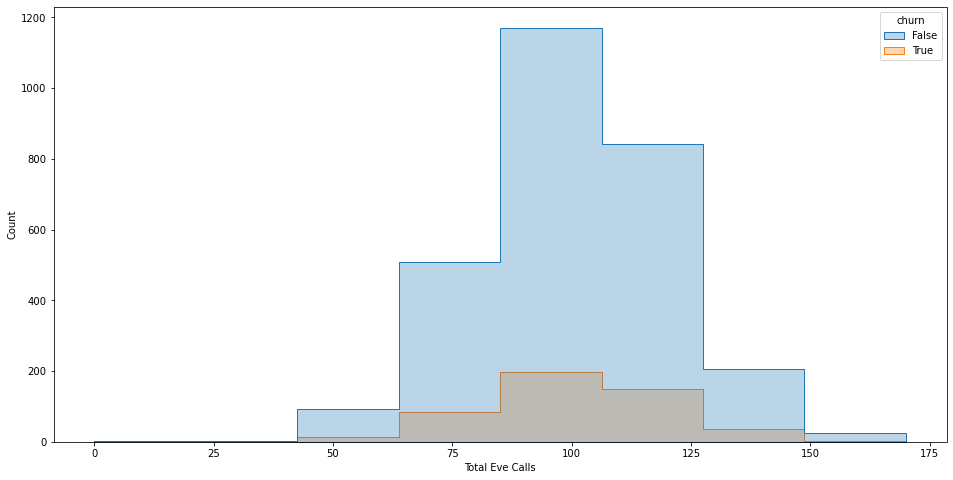

In [142]:
fig,ax = plt.subplots(figsize=(16,8))
ax = sns.histplot(data=df,x='total eve calls', hue='churn', alpha=0.3, bins=8, element='step', stat='count')
ax.set(xlabel='Total Eve Calls', ylabel='Count')
plt.show()

## International Plan


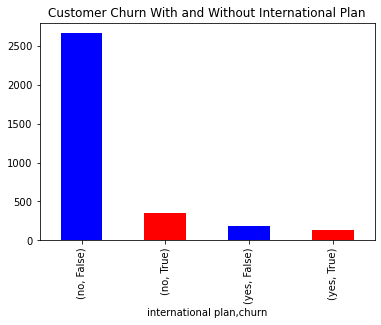

In [160]:
ip_df = df[['international plan','churn']]

ip_df.value_counts().plot(kind='bar', color=('b','r'), title='Customer Churn With and Without International Plan');

## Total Night Charge

In [143]:
##
tot_ec = df.groupby(['churn'])
tot_ec.agg({'total eve calls': ['mean', 'min', 'max','std']})

total eve calls                    
                 mean min  max        std
churn                                    
False      100.038596   0  170  19.958414
True       100.561077  48  168  19.724711

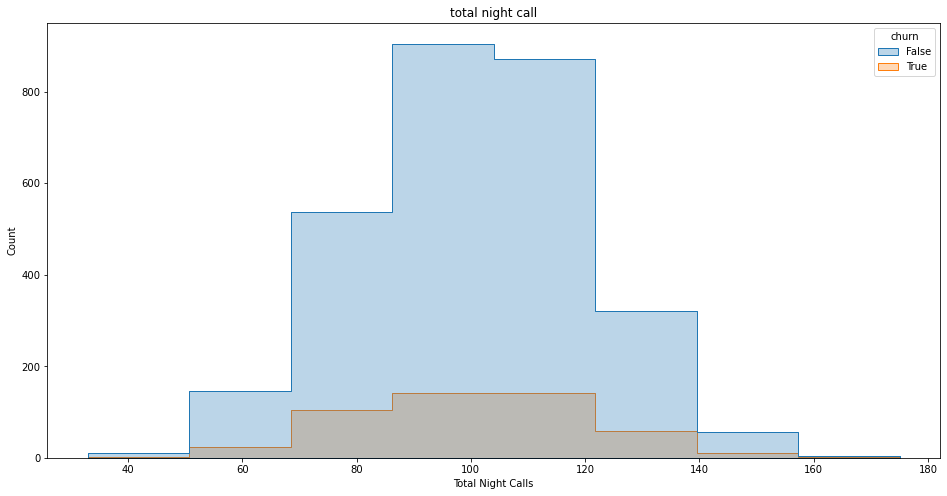

In [145]:
fig,ax = plt.subplots(figsize=(16,8))
ax = sns.histplot(data=df,x='total night calls', hue='churn', alpha=0.3, bins=8, element='step', stat='count')
ax.set(xlabel='Total Night Calls', ylabel='Count', title='total night call')
plt.show()

These are all very similar.  Not a lot of information gained from this.


## Reccomendations

### Total Eve Calls

Focus on ranges of evening calls where customer churn is higher. 

### International Plan

International customers are much more likely to churn.  It would be good to look into whether or not they are just signing up for an international plan with SyriaTel for travel purposes or if they are truly disatisfied with the service.  

### Total Night Charge

Focus on ranges of night calls where customer churn is higher.

## Other Reccomendations based on previous model

previous model parameters changed based on scoring algorithm and fixing some columns that were incorrectly transformed.  That being said the data found from the exploration of those features is still very usefull, even though they are no longer the top features

### Total Day Charge Recommendation

Look into flat rate charge offers for customers that have over $45 total day charge.  These high activity customers may stick around if there day charges are capped.
    

### Area Code Recommendation

Investigate area code 510.  High churn rate amoung low day charge customers.  Is there greater competition in this area 
    
### Customer Service Call Recommendation

Ensure customer satisfication before the 4th service call.  Redirect 2nd and 3rd service calls to better or higher level employees.